In [24]:
def set_random_initial_conds_for_nodes(bifurcation,noise_strength,tsteps,d,dt,parameters,realizations,noise):

    #unpack parameters
    alpha=parameters['alpha']
    beta=parameters['beta']
    gamma=parameters['gamma']
    delta=parameters['delta']
    epsilon=parameters['epsilon']
    tau=parameters['tau']
    sigma=parameters['sigma']
    mu=parameters['mu']
    A=parameters['A']
    N=parameters['N']
    nocontrol=np.zeros((tsteps+4000,N))

    #set random initials on circle with set amplitudes
    if bifurcation=='low':
        ini_y=np.random.uniform(size= N)/2+0.1
        ini_z=np.random.uniform(size= N)/5+.5
    elif bifurcation=='high':
        ini_y=np.random.uniform(size= N)
        ini_z=np.random.uniform(size= N)*0.3+1.0
    
    ini_transient=np.dstack((ini_y,ini_z)).transpose()
    ini_transient=ini_transient.reshape(2,N)
    #print(ini_transient)

    return ini_transient

In [45]:
import sys
import os
absFilePath = os.path.abspath('example_state_switching.py')
fileDir = os.path.dirname(absFilePath)
parentDir = os.path.dirname(fileDir)

import functions as functions
from FRoptimize import FR_algorithm

import numpy as np
import pickle
import matplotlib.pyplot as plt
from pylab import figure, cm
import numpy.random as rnd
np.random.seed(42)

goal='switch'
bifurcation='low'
switchfromto='lowtohigh' 
noise_strength= 0.0 
realizations=1
noise=0
parameters_low = functions.set_parameters(goal,bifurcation,parentDir)
parameters_high = functions.set_parameters(goal,'high',parentDir)
# 200 trajectories
A = np.zeros((200,200))
parameters_low['A'] = A
parameters_low['N'] = 200
parameters_high['A'] = A
parameters_high['N'] = 200

#Set dimensions
T= 100 #simulation and control time 
dt=0.1 #time stepsize
tsteps=int(T/dt) #number of timesteps
d=2 #dimension of each FitzHugh-Nagumo node

#set parameters of the cost functional
I_p_in= 0.0005
I_p=np.zeros((tsteps,parameters_low['N']))
I_p[int(tsteps-25/dt):]=I_p_in*np.ones((int(25/dt),parameters_low['N']))
I_e= 0.1#1.0 
I_s= 0.0


#choose initial condition for control
control=2*rnd.random([tsteps,parameters_low['N']])-1 #-np.ones((tsteps,parameters_low['N']))*0.002
#control=control.reshape(tsteps*parameters_low['N'])

ic_state_low=functions.set_random_initial_conds_for_nodes('low',noise_strength,tsteps,d,dt,parameters_low,realizations,noise)
ic_state_high=functions.set_random_initial_conds_for_nodes('high',noise_strength,tsteps,d,dt,parameters_high,realizations,noise)


In [38]:
def give_target(parameters, ic, control):
    alpha=parameters['alpha']
    beta=parameters['beta']
    gamma=parameters['gamma']
    delta=parameters['delta']
    epsilon=parameters['epsilon']
    tau=parameters['tau']
    sigma=parameters['sigma']
    mu=parameters['mu']
    A=parameters['A']
    N=parameters['N']
    #control=np.zeros((tsteps,N))

    target_state=functions.runge_kutta_FHN_network(ic, control,  tsteps , d , dt , N, alpha , beta, gamma, delta, epsilon, tau, mu ,sigma, A)#[:,0,:]
    return target_state

In [46]:
samples_high = give_target(parameters_high, ic_state_high,control)
samples_low = give_target(parameters_low, ic_state_low,control)

In [28]:
samples_high.shape

(1000, 2, 200)

In [40]:
samples_high_reshape = samples_high.transpose(2,0,1).reshape(-1,samples_high.shape[1])

In [47]:
samples_low_reshape = samples_low.transpose(2,0,1).reshape(-1,samples_low.shape[1])

In [8]:
samples_high_reshape.shape

(200000, 2)

[Text(0, 0.5, '$x_1$'), Text(0.5, 0, '$t$')]

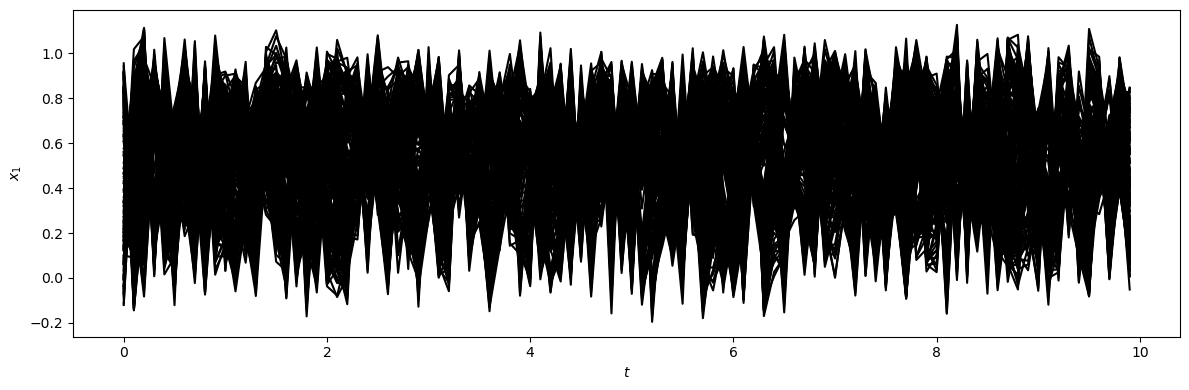

In [42]:
# Visualize first 100 steps of the training data
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(12, 4))
X = samples_high_reshape.T
t = np.arange(0, T*dt, dt)
for traj_idx in range(200):
    x = X[:, traj_idx::200]
    axs.plot(t[0:100], x[0, 0:100], 'k')
axs.set(
        ylabel=r'$x_1$',
        xlabel=r'$t$')

[Text(0, 0.5, '$x_1$'), Text(0.5, 0, '$t$')]

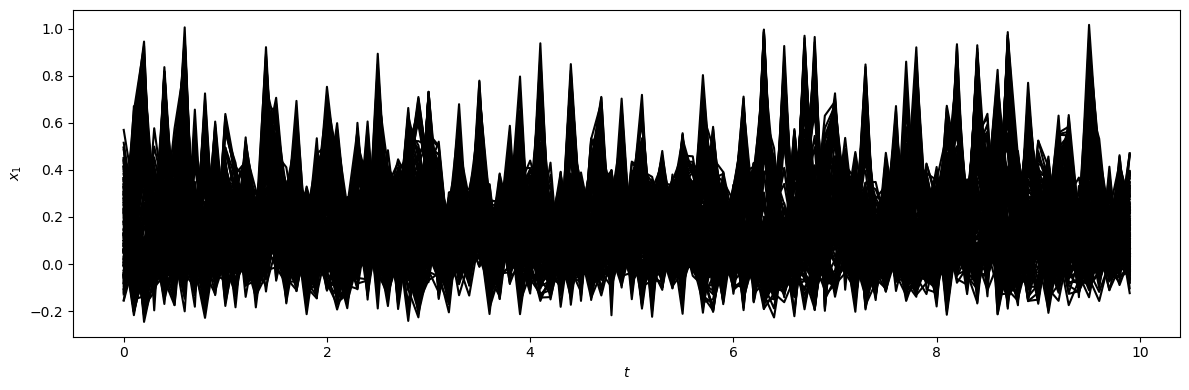

In [48]:
# Visualize first 100 steps of the training data
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(12, 4))
X = samples_low_reshape.T
t = np.arange(0, T*dt, dt)
for traj_idx in range(200):
    x = X[:, traj_idx::200]
    axs.plot(t[0:100], x[0, 0:100], 'k')
axs.set(
        ylabel=r'$x_1$',
        xlabel=r'$t$')

In [52]:
np.savetxt("fhn_high.csv", samples_high_reshape.T, delimiter=",")

In [53]:
np.savetxt("fhn_low.csv", samples_low_reshape.T, delimiter=",")

## test samples

In [54]:
def square_wave(step):
    return (-1.0) ** (round(step / 30.0))

In [61]:
control_test = np.array([-square_wave(step+1) for step in range(tsteps)])

In [58]:
parameters_test = functions.set_parameters(goal,bifurcation,parentDir)
A = np.zeros(1)
parameters_test['A'] = A
parameters_test['N'] = 1

ic_state_test=functions.set_random_initial_conds_for_nodes('low',noise_strength,tsteps,d,dt,parameters_test,realizations,noise)

In [60]:
ic = np.array([[0.5],[0.5]])

In [62]:
samples_test = give_target(parameters_test, ic,control_test)

In [63]:
samples_test.shape

(1000, 2, 1)

In [64]:
samples_test_reshape = samples_test.transpose(2,0,1).reshape(-1,samples_test.shape[1])

In [67]:
samples_test_reshape.shape

(1000, 2)

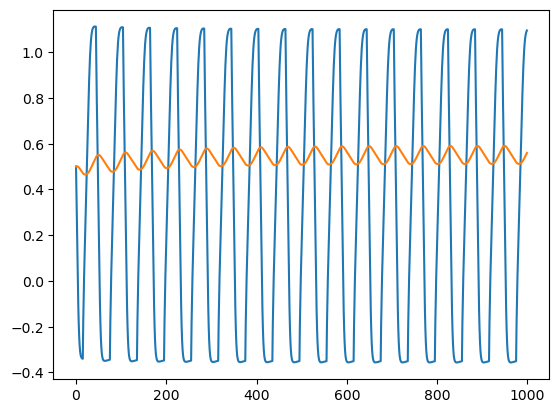

In [66]:
plt.plot(samples_test_reshape)

In [68]:
np.savetxt("fhn_test.csv", samples_test_reshape, delimiter=",")